In [1]:
from IPython.display import HTML
HTML('''
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb

from tqdm.notebook import trange
from tqdm import tqdm
import itertools
import time
from collections import Counter


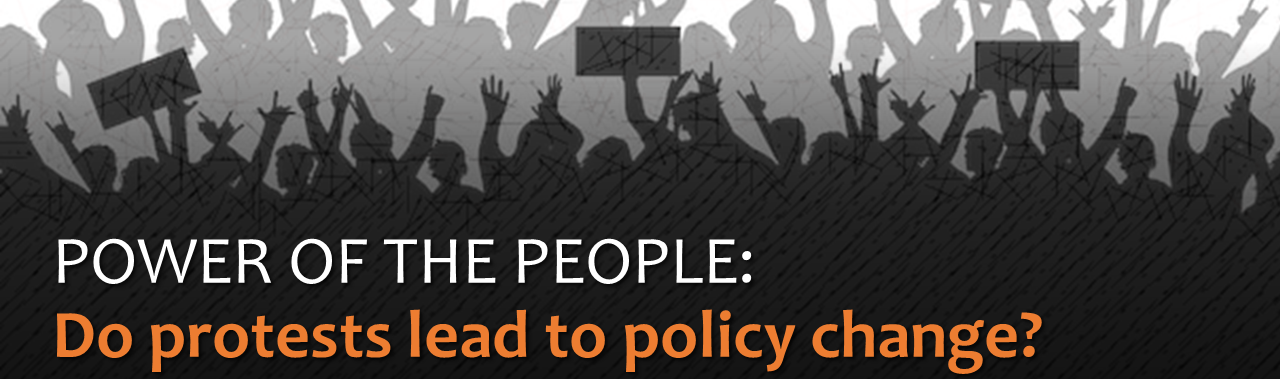

<h2 style="color: darkorange">Executive Summary</h2>

<span style="font-size: 16px">
One perspective in policy analysis describes the policymaking process as stable and incremental but at times sudden and unexpected events, e.g., wars, crises, and protests, can create opportunities for positive change.<sup>1</sup> Indeed, protests and demonstrations have long been used as modes to express discontent on government policy. 
    
In this study, we looked at protests from around the world using the Carnegie Endowment for International Peace's **Global Protest Tracker** dataset <sup>2</sup> to see what characteristics define a significant protest outcome or policy change. From 2017 to 2022, the dataset contains information on over 400 protests in 132 countries. Changes in a specific policy or law, as well as the resignation of government officials as a result of protests, are examples of policy changes.
    
Before running the models, the dataset was preprocessed to convert columns to numeric values. The dataset was also balanced through the use of random under sampling. The models' baseline performance were not able to outperformed the 1.25PCC of 62.50%. The **'GBM'** model had the highest test accuracy of 64.22% after parameter tuning, followed by **'Random Forest'**. In both models, 'Duration_log' is the top predictor.

Although the top performing models outperformed the 1.25PCC, the highest test accuracy score of 64.22% is significantly low. It is recommended that future analyses try other methods of correcting class imbalance and compare results, increase simulation size, and add features that affect protests and protest outcomes based on literature, such as chances of rain.


<h2 style="color: darkorange">Highlights</h2>

<span style="font-size: 16px">

1. The values in the dataset were all string types, necessitating several data cleaning and preprocessing steps. Features such as the interaction between size and duration of protests (`Large_Long`), and `Headline_PIT` were added in the dataset to include measure of individual motivation and persistence to join protests. 

    
2. Given extreme values for the 'Size' and 'Duration' features, the final dataset was log transformed, and the original columns were removed for analysis.

    
3. There is class imbalance and this was corrected using random under sampling method. The models' baseline performance did not meet the needed test accuracy, but after some parameter tuning, the highest test accuracy was able to exceed the 1.25PCC.

<h2 style="color: darkorange">Methodology</h2>

<span style="font-size: 16px">

* Data exploration and data preprocessing
* Modeling
* Results and Discussion
* Conclusion and Recommendation

<h2 style="color: darkorange">Data Exploration and Preprocessing</h2>

<span style="font-size: 16px"> The initial dataset has 21 columns with all column value types as strings. 

In [2]:
df = pd.read_csv('Global Protest Tracker - View Data.csv', header=1)
df.head()

,Country,Protest Name,Start Date,Freedom Rating (Status),Triggers,Motivations,Peak Size,Key Participants,Duration,Outcomes,...,Economic motivation?,Political motivation?,Corruption motivation?,Size category,Protests with a significant outcome,"Large protests (Over 100,000 protesting)",Violent government response,Long protests (more than 3 months),Coronavirus-related protests,Capital city
0,Afghanistan,Electoral protests,19-Nov,Not free,Delays in the announcement of final vote count...,Concerns about electoral fraud and controversy...,">1,000",Supporters of opposition presidential candidat...,2 months,No policy/leadership change in response to pro...,...,NaN,X,X,Thousands,NaN,NaN,NaN,NaN,X,Kabul
1,Afghanistan,“Commander Sword” protests,18-Nov,Not free,The arrest of a popular ethnic Hazara militia ...,Conflict between the national government and e...,"<1,000",Ethnic Hazaras.,1 week,The arrested commander was released after two ...,...,X,X,X,Over 1 million,X,X,NaN,X,NaN,Kabul
2,Afghanistan,Truck bombing protests,17-Jun,Not free,"A truck bombing on May 31, 2017, which killed ...",Anger at the inability of President Ashraf Gha...,">1,000",General public.,1 week,Ghani fired two ministers but also engaged in ...,...,NaN,X,X,Tens of thousands,NaN,NaN,NaN,X,NaN,Kabul
3,Albania,Rising price protests,22-Mar,Partly free,Rapid increases in food and fuel prices.,Frustration with high poverty and low wages an...,">1,000",General public.,1 week,No policy/leadership change in response to pro...,...,X,X,X,Thousands,NaN,NaN,NaN,X,NaN,Tirana
4,Albania,Police violence protests,20-Dec,Partly free,The fatal shooting of Klodian Rasha by an offi...,Concerns about excessive force being used by l...,>500,"General public, especially youth.",1 week,No policy/leadership change in response to pro...,...,NaN,X,NaN,Hundreds,NaN,NaN,X,NaN,X,Tirana


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Country                                   401 non-null    object
 1   Protest Name                              401 non-null    object
 2   Start Date                                401 non-null    object
 3   Freedom Rating (Status)                   401 non-null    object
 4   Triggers                                  401 non-null    object
 5   Motivations                               401 non-null    object
 6   Peak Size                                 401 non-null    object
 7   Key Participants                          400 non-null    object
 8   Duration                                  401 non-null    object
 9   Outcomes                                  400 non-null    object
 10  Active protests                           27 non-n

<span style="font-size: 16px">

**Preprocessing steps done:**
* consistency check for string formatting
* filling missing values
* changing string values to numeric 
* log transform values (`Size category` and `Duration`)
* dropped columns not needed for analysis
* dropped 3 rows with null values under `Size category` column
* renamed columns to shorten names for easier calling of columns
* Added feature on the interaction between large and long protest
* Merged dataset on `Headline_PIT`<sup>3</sup> as measure of peoples' persistence and motivation to participate in protests (domain knowledge)


In [4]:
# Make sure all country name has consistent format
df['Country'] = df['Country'].str.title() 

# Fill all missing values with 0 and replace X with 1
df = df.fillna({'Active protests':0, 'Economic motivation?':0, 'Political motivation?':0,
                'Corruption motivation?':0, 'Protests with a significant outcome':0,
                'Large protests (Over 100,000 protesting)':0, 'Violent government response':0,
                'Long protests (more than 3 months)':0, 'Coronavirus-related protests':0})
df = df.replace({'X':1})

# Change string size category into integers and log transform
df['Size category']= df['Size category'].replace({'Thousands': 1000, 'Over 1 million': 1000000, 
                                                  'Tens of thousands': 10000, 'Hundreds': 100, 'Millions': 1000000, 
                                                  'Hundreds of thousands': 100000, 'Hundreds of of thousands': 100000,
                                                  'Unknown': np.nan, 'Huundreds of thousands': 100000, 
                                                  'Tens of millions': 10000000, 'Tens': 10,'Thosuands': 1000})
df['Size_log'] = np.log(df['Size category'])

# Change freedom status to dummy
#df['Freedom Rating (Status)'].unique()
df['Freedom Rating (Status)'] = df['Freedom Rating (Status)'].replace({'Partly Free':'Partly free', 'Partly freee': 'Partly free'})

df['Freedom Rating (Status)'] = df['Freedom Rating (Status)'].replace({'Not free': 0, 
                                                                       'Partly free': 1, 
                                                                       'Free': 2 })


In [5]:
# replaced duration in words (days, weeks, months, years,) with integer values
duration = df['Duration'].value_counts()
print(df['Duration'].value_counts())
df['Duration_str']= df['Duration']
replaced = []
for i,v in duration.iteritems():
    replaced.append(i)

days = [1,7,30,60,1, 14,4*30,3*30,5*30,21,14*30,365,8*30,2,3,6*30,365+180,
        330,10,365+180,5,365+(4*20),16*27,7*30,12*20,24*27,11*30,10*30,1+7,
        24*20,42,15*30,60+7,28,365+60,9*27,15*27,365+90,10*27,365+270,21+1,
        7*20,30*27,21+120+21,365+(8*20),365+150,13*27,11*27,9*30,270,365+60,
        4*27]
df['Duration']=df['Duration'].replace(replaced, days)
  

1 day                                                                                    74
1 week                                                                                   58
1 month                                                                                  49
2 months                                                                                 35
Active                                                                                   28
2 weeks                                                                                  26
4 months                                                                                 15
3 months                                                                                 12
5 months                                                                                 11
3 weeks                                                                                  10
14 months                                                                       

In [6]:
# transform duration to log
df['Duration_log'] = np.log(df['Duration']) 

In [7]:
# drop columns not needed for analysis
df = df.drop(['Protest Name', 'Triggers', 'Motivations', 'Peak Size', 
               'Key Participants', 'Outcomes', 'Capital city', 'Duration_str'], axis=1)

In [8]:
#check for null values and drop null values
df.isna().sum()
df.dropna(inplace=True)

In [9]:
#rename columns 
df =df.rename(columns={'Start Date':'Start_date',
                       'Freedom Rating (Status)':'Frdm_rating',
                       'Active protests':'Active', 'Economic motivation?':'Econ_motive',
                       'Political motivation?': 'Pol_motive', 'Corruption motivation?':'Corr_motive',
                       'Size category':'Size', 'Protests with a significant outcome': 'Outcome', 
                       'Large protests (Over 100,000 protesting)':'Large_protest',
                       'Violent government response':'Violent_govresp',
                       'Long protests (more than 3 months)':'Long_protest',
                       'Coronavirus-related protests':'Covid_prtst'})

In [10]:
# added new feature on interaction of large and long protest
df['Large_Long'] = df['Large_protest']*df['Long_protest']

In [11]:
df2 = pd.read_excel('add_PIT.xlsx', sheet_name="Sheet2")
df2['Country'] = df2['Country'].str.title()
df3 = pd.merge(df, df2, on='Country')


### Visualizing the data

<span style="font-size: 16px">
France has the highest number of protests in the observed period with protests having economic and political motivations.

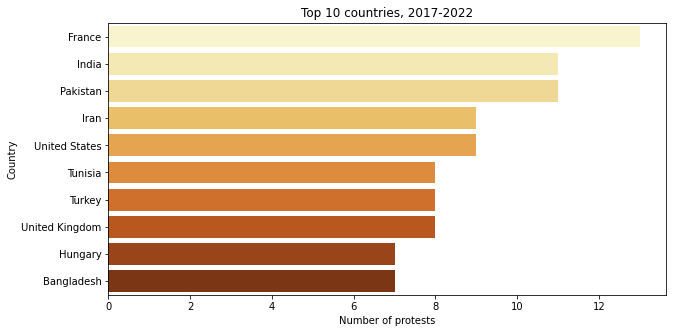

In [12]:
#sns.set_style("whitegrid")

df_countrycount = df3['Country'].value_counts().nlargest(10)
fig, axes = plt.subplots(1, 1, figsize=(10,5))
ax = sns.barplot(x=df_countrycount, y=df_countrycount.index, palette='YlOrBr')
ax.set_title('Top 10 countries, 2017-2022')
ax.set_xlabel('Number of protests')
ax.set_ylabel('Country')
plt.show()

<span style="font-size: 16px"> There is class imbalance in the dataset. Understandably, changing policies through protests or mass demonstration is difficult and often requires a confluence of events.

Population per class:     0
0  290
1  108
Proportion Chance Criterion: 60.46%
1.25 * Proportion Chance Criterion: 75.57%


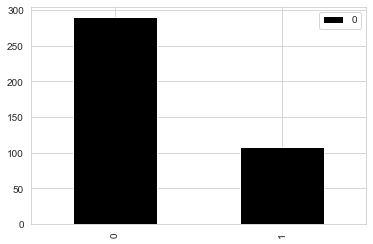

In [13]:
color = ['black']
sns.set_style("whitegrid")
protest_counts = Counter(df3['Outcome'])
df_new = pd.DataFrame.from_dict(protest_counts, orient='index')
df_new.plot(kind='bar', color=color)

num=(df_new[0]/df_new[0].sum())**2

print("Population per class:{}".format(df_new))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

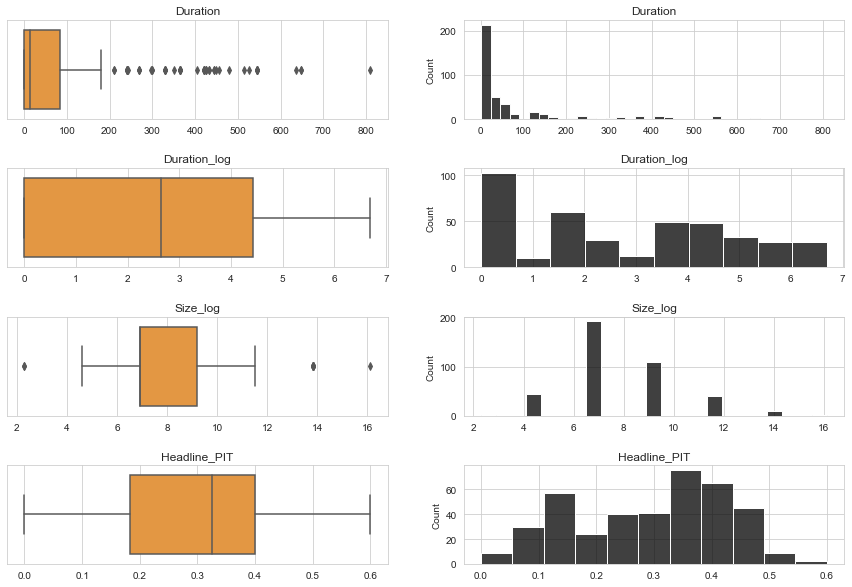

In [14]:
numeric_cols = ['Duration', 'Duration_log', 'Size_log', 'Headline_PIT']

fig, axes = plt.subplots(figsize=(15,10), nrows=4, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for row, feat in enumerate(numeric_cols):
    sns.boxplot(x=df3[feat], ax=axes[row][0], palette='YlOrBr')
    sns.histplot(df3[feat], ax=axes[row][1], color='black')
    axes[row][0].set_xlabel('')
    axes[row][1].set_xlabel('')
    axes[row][0].set_title(feat)
    axes[row][1].set_title(feat)
plt.show()

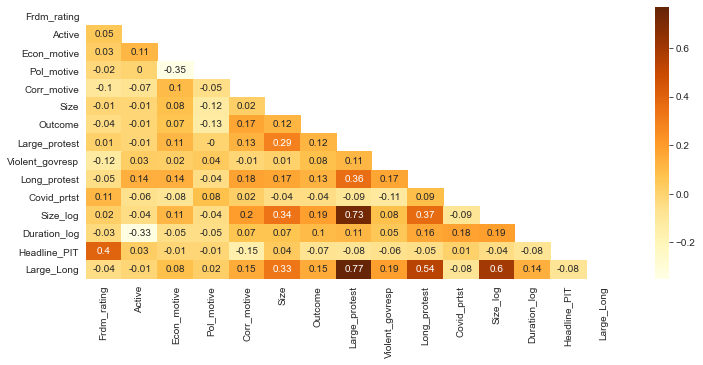

In [15]:
corr_ = df3[['Frdm_rating', 'Active', 'Econ_motive', 'Pol_motive', 'Corr_motive', 'Size', 'Outcome',
       'Large_protest', 'Violent_govresp', 'Long_protest', 'Covid_prtst',
       'Size_log', 'Duration_log', 'Headline_PIT', 'Large_Long']]

corr_df = corr_.corr()
matrix = np.triu(corr_df)
sns.heatmap(round(corr_df, 2), annot=True, cmap='YlOrBr', mask=matrix)
plt.gcf().set_size_inches(12, 5)
plt.show()

<span style="font-size: 16px">

* There is strong positive correlation between `Size` and `Duration`, its transformation and interaction which is as expected.
* Weak positive correlation also exists between the dummy variables for `Large_protest` and `Long_protest`.
* The `Headline_PIT` has a weak positive correlation with `frdm_rating`.

**Final Dataset Used for Analysis** 

| Column Name| Description | Data Type | Variable Category | Variable Type
|-|-|-|-|-|
|Outcome| Significant outcome of the protest, whether it lead to a change in policy | Numeric | Categorical | Output
|Frdm_rating| Freedom House rating of the country as Free, Partly Free or Not Free | Numeric | Categorical | Input
|Active| Dummy variable if protest is still active/ongoing | Numeric | Categorical | Input
|Econ_motive| Dummy variable if protest is economically-motivated | Numeric | Categorical | Input
|Pol_motive| Dummy variable if protest is politically-motivated | Numeric | Categorical | Input
|Corr_motive| Dummy variable if protest is motivated by reports of corruption | Numeric | Categorical | Input
|Large_protest| Dummy variable, if protest reached peak size of 100,000 or more participants | Numeric | Categorical | Input
|Violent_govresp| Dummy variable, if protest was met with violent government response | Numeric | Categorical | Input
|Long_protest| Dummy variable, if protest lasted for three months or more | Numeric | Categorical | Input
|Covid_protest| Dummy variable, if protest is related to covid | Numeric | Categorical | Input
|Size_log| Size of protest, log transformed | Numeric | Continuous | Input
|Duration_log| Duration of protest, log transformed | Numeric | Continuous | Input
|Large_Long| Added, interaction of size and duration of protest | Numeric | Categorical | Input
|Headline_PIT| Added, headline personal income tax as measure of motivation and persistence to protest| Numeric | Continuous | Input

<h2 style="color: darkorange">Modeling</h2>

**Split and Scale**

In [16]:
X_ = df3.drop(['Country', 'Outcome', 'Size', 'Start_date', 'Duration'], axis=1)
y_ = df3['Outcome']
X_cols = X_.columns
X_.head()

,Frdm_rating,Active,Econ_motive,Pol_motive,Corr_motive,Large_protest,Violent_govresp,Long_protest,Covid_prtst,Size_log,Duration_log,Large_Long,Headline_PIT
0,0,0,0,1,1,0,0,0,1,6.907755,4.094345,0,0.20
1,0,0,1,1,1,1,0,1,0,13.815511,1.945910,1,0.20
2,0,0,0,1,1,0,0,1,0,9.210340,1.945910,0,0.20
3,1,0,1,1,1,0,0,1,0,6.907755,1.945910,0,0.23
4,1,0,0,1,0,0,1,0,1,4.605170,1.945910,0,0.23


-------

<span style="font-size: 16px">
    
    
    
After correcting for class imbalance using the random undersampling with `imblearn`, the resampled data set has equal class outcomes, thus total dataset used for the study is 216.

In [17]:
# correcting for class imbalance
import imblearn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
X, y = rus.fit_resample(X_, y_)

print('Original dataset shape:', Counter(y_))
print('Resample dataset shape', Counter(y))

Original dataset shape: Counter({0: 290, 1: 108})
Resample dataset shape Counter({0: 108, 1: 108})


Population per class after undersampling:     0
0  108
1  108
New Proportion Chance Criterion: 50.00%
New 1.25 * Proportion Chance Criterion: 62.50%


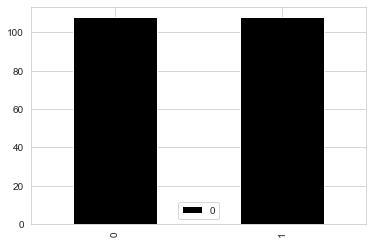

In [26]:
color = ['black']
sns.set_style("whitegrid")
protest_ = Counter(y)
df_n = pd.DataFrame.from_dict(protest_, orient='index')
df_n.plot(kind='bar', color=color)

num=(df_n[0]/df_n[0].sum())**2

print("Population per class after undersampling:{}".format(df_n))

print("New Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("New 1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

In [18]:
# Scale using standard scaler
stdsc = StandardScaler()
X = stdsc.fit_transform(X.astype(float))
X = pd.DataFrame(X, columns=X_cols)
X.head()

,Frdm_rating,Active,Econ_motive,Pol_motive,Corr_motive,Large_protest,Violent_govresp,Long_protest,Covid_prtst,Size_log,Duration_log,Large_Long,Headline_PIT
0,0.029078,-0.242536,-0.782266,0.353553,1.922408,-0.447214,-0.620174,-0.620174,-0.319438,0.421135,-0.150770,-0.353553,-1.681767
1,1.285253,-0.242536,-0.782266,0.353553,-0.520181,-0.447214,-0.620174,-0.620174,-0.319438,-0.612559,-1.520613,-0.353553,1.300449
2,-1.227097,-0.242536,-0.782266,0.353553,-0.520181,-0.447214,-0.620174,-0.620174,-0.319438,-0.612559,-0.510559,-0.353553,0.123259
3,-1.227097,-0.242536,-0.782266,0.353553,-0.520181,-0.447214,1.612452,-0.620174,-0.319438,0.421135,-0.510559,-0.353553,0.358697
4,0.029078,-0.242536,-0.782266,0.353553,-0.520181,-0.447214,1.612452,-0.620174,-0.319438,-0.612559,-0.510559,-0.353553,-0.347618


### Baseline Performance

In [19]:
Number_trials = 100

def train_knn(X, y):
    score_train = []
    score_test = []

    for seed in trange(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        neighbors_settings = range(1,len(X_train))
        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:   
            clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
            clf.fit(X_train, y_train)    
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_test, y_test))

        score_train.append(acc_train)
        score_test.append(acc_test)   
        
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(train_score), np.amax(test_score),'N_Neighbor = {0}'.format(np.argmax(test_score)+1), 'NA',run_time]

def train_logistic(X, y, reg):
    C = [1]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in C:
            if reg == 'l1':
                #lr = LogisticRegression(C=alpha_run, penalty=reg, solver='liblinear').fit(X_train, y_train)
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='liblinear', max_iter=10_000).fit(X_train, y_train)

            if reg == 'l2':
                #lr = LogisticRegression(C=alpha_run, penalty=reg, dual=False).fit(X_train, y_train)
                lr = LogisticRegression(C=alpha_run, penalty=reg, dual=False, max_iter=10_000).fit(X_train, y_train)
            
            
            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            coefs=lr.coef_ 
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
    
    mean_coefs = np.mean(np.mean(weighted_coefs, axis=0), axis=1)
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    run_time = (time.time() - start_time)
    return ['Logistic ({0})'.format(reg), np.amax(train_score), np.amax(test_score), \
            'C = {0}'.format(C[np.argmax(test_score)]), top_predictor, run_time]

def train_svm(X, y, reg):
    C = [1]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False, max_iter=1_000_000).fit(X_train, y_train)
     
            if reg == 'l2':                
                svc = LinearSVC(C=alpha_run, penalty=reg, max_iter=1_000_000).fit(X_train, y_train)

            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
            coefs = svc.coef_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 
    mean_coefs = np.mean(np.mean(weighted_coefs, axis=0), axis=1) 
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    run_time = (time.time() - start_time)
    return ['Linear SVM ({0})'.format(reg), np.amax(train_score), np.amax(test_score), \
            'C = {0}'.format(C[np.argmax(test_score)]), top_predictor,run_time]

def train_DT(X, y, reg):
    max_depth=[1]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_depth_run in max_depth:
            svc = DecisionTreeClassifier(max_depth=max_depth_run).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0)     
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
#     fig, ax = plt.subplots(figsize=(3,7))
#     ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
#     ax.set_yticks(np.arange(coefs_count))
#     ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['Decision Tree', np.amax(train_score), np.amax(test_score), \
            'Max_features = {0}'.format(max_depth[np.argmax(test_score)]), top_predictor,run_time]

def train_RF(X, y, reg):
    max_features_tuning=[0.1]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_features_run in max_features_tuning:
            svc = RandomForestClassifier(n_estimators=100, max_features=max_features_run,  max_depth=None).fit(X_train, y_train) 
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0)      
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
#     fig, ax = plt.subplots(figsize=(3,7))
#     ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
#     ax.set_yticks(np.arange(coefs_count))
#     ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['Random Forest', np.amax(train_score), np.amax(test_score), \
            'Max_features = {0}'.format(max_features_tuning[np.argmax(test_score)]), top_predictor,run_time]


def train_GBM(X, y, reg):
    max_features_tuning=[0.1]

    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_features_run in max_features_tuning:
            svc = GradientBoostingClassifier(n_estimators=100, max_depth=3, max_features=max_features_run).fit(X_train, y_train)
            #svc = GradientBoostingClassifier(n_estimators=100, max_depth=1, learning_rate=0.1, max_features=max_features_run).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0)    
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
#     fig, ax = plt.subplots(figsize=(3,7))
#     ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
#     ax.set_yticks(np.arange(coefs_count))
#     ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['Gradient Boosting Method', np.amax(train_score), np.amax(test_score),\
            'Max_features = {0}'.format(max_features_tuning[np.argmax(test_score)]), top_predictor,run_time]

def train_ADAGBM(X, y, reg):
    max_features_tuning=[0.1]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_features_run in max_features_tuning:
            svc = AdaBoostClassifier(n_estimators=50, algorithm='SAMME.R', learning_rate=0.1).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0)   
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)


    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
#     fig, ax = plt.subplots(figsize=(3,7))
#     ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
#     ax.set_yticks(np.arange(coefs_count))
#     ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['Ada Boosting Method', np.amax(train_score), np.amax(test_score), \
            'Max_features = {0}'.format(max_features_tuning[np.argmax(test_score)]), top_predictor,run_time]


def train_LGBM(X, y, reg):
    max_features_tuning=[0.1]

    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_features_run in max_features_tuning:
            svc = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.01, objective='binary').fit(X_train, y_train)
            #svc = lgb.LGBMClassifier(n_estimators=150,max_depth=3, num_leaves=4, learning_rate=0.01, objective='binary').fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0)      
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
#     fig, ax = plt.subplots(figsize=(3,7))
#     ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
#     ax.set_yticks(np.arange(coefs_count))
#     ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['Light GBM Method', np.amax(train_score), np.amax(test_score), \
            'Max_features = {0}'.format(max_features_tuning[np.argmax(test_score)]), top_predictor,run_time]

def train_XGBM(X, y, reg):
    max_features_tuning=[0.1]

    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_features_run in max_features_tuning:
            svc = xgb.XGBClassifier(n_estimators=100, max_depth=3).fit(X_train, y_train)
            #svc = lgb.LGBMClassifier(n_estimators=150,max_depth=3, num_leaves=4, learning_rate=0.01, objective='binary').fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0)       
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
#     fig, ax = plt.subplots(figsize=(3,7))
#     ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
        
#     ax.set_yticks(np.arange(coefs_count))
#     ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return [' XGBM Method', np.amax(train_score), np.amax(test_score), \
            'Max_features = {0}'.format(max_features_tuning[np.argmax(test_score)]), top_predictor,run_time]

In [20]:
start_time = time.time()
a_norm = train_knn(X,y)
start_time = time.time()
b_norm = train_logistic(X,y, reg='l1')
start_time = time.time()
c_norm = train_logistic(X,y, reg='l2')
start_time = time.time()
d_norm = train_svm(X,y,reg='l2')
start_time = time.time()
e_norm = train_svm(X,y,reg='l1')
start_time = time.time()
f_norm = train_DT(X,y,reg='none')
start_time = time.time()
g_norm = train_RF(X,y,reg='none')
start_time = time.time()
h_norm = train_GBM(X,y,reg='none')
start_time = time.time()
i_norm = train_ADAGBM(X,y,reg='none')
start_time = time.time()
j_norm = train_LGBM(X,y,reg='none')
start_time = time.time()
k_norm = train_XGBM(X,y,reg='none')


cols = ['Machine Learning Method',
         'Train Accuracy',
        'Test Accuracy',
         'Best Parameter',
         'Top Predictor Variable',
         'Run Time']

df4 = pd.DataFrame(columns=cols)


df4.loc[0] = a_norm
df4.loc[1] = b_norm
df4.loc[2] = c_norm
df4.loc[3] = d_norm
df4.loc[4] = e_norm
df4.loc[5] = f_norm
df4.loc[6] = g_norm
df4.loc[7] = h_norm
df4.loc[8] = i_norm
df4.loc[9] = j_norm
df4.loc[10] = k_norm

df4
df4.sort_values('Test Accuracy', ascending=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,Machine Learning Method,Train Accuracy,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
7,Gradient Boosting Method,0.877963,0.622778,Max_features = 0.1,Duration_log,8.570565
6,Random Forest,0.996111,0.622407,Max_features = 0.1,Duration_log,24.460102
0,kNN,0.996111,0.609074,N_Neighbor = 17,NA,920.986659
10,XGBM Method,0.961667,0.606667,Max_features = 0.1,Pol_motive,5.808138
3,Linear SVM (l2),0.661235,0.582222,C = 1,Frdm_rating,1.880229
2,Logistic (l2),0.663272,0.581481,C = 1,Frdm_rating,1.154018
4,Linear SVM (l1),0.659753,0.580926,C = 1,Frdm_rating,0.884742
1,Logistic (l1),0.654136,0.578889,C = 1,Frdm_rating,0.973313
8,Ada Boosting Method,0.672654,0.562222,Max_features = 0.1,Duration_log,12.637608
9,Light GBM Method,0.696728,0.540741,Max_features = 0.1,Duration_log,3.325283


### Hyperparameter Tuning

In [21]:
Number_trials = 100

def train_knn(X, y):
    score_train = []
    score_test = []

    for seed in trange(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        neighbors_settings = range(1,len(X_train))
        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:   
            clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
            clf.fit(X_train, y_train)    
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_test, y_test))

        score_train.append(acc_train)
        score_test.append(acc_test)   
        
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(train_score), np.amax(test_score),'N_Neighbor = {0}'.format(np.argmax(test_score)+1), 'NA',run_time]

def train_logistic(X, y, reg):
    # Hyperparameter tuning
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in C:
            if reg == 'l1':
                #lr = LogisticRegression(C=alpha_run, penalty=reg, solver='liblinear').fit(X_train, y_train)
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='liblinear', max_iter=10_000).fit(X_train, y_train)

            if reg == 'l2':
                #lr = LogisticRegression(C=alpha_run, penalty=reg, dual=False).fit(X_train, y_train)
                lr = LogisticRegression(C=alpha_run, penalty=reg, dual=False, max_iter=10_000).fit(X_train, y_train)
            
            
            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            coefs=lr.coef_ 
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
    
    mean_coefs = np.mean(np.mean(weighted_coefs, axis=0), axis=1)
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    run_time = (time.time() - start_time)
    return ['Logistic ({0})'.format(reg), np.amax(train_score), np.amax(test_score), \
            'C = {0}'.format(C[np.argmax(test_score)]), top_predictor, run_time]

def train_svm(X, y, reg):
    # Hyperparameter tuning
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False, max_iter=10_000_000).fit(X_train, y_train)
     
            if reg == 'l2':                
                svc = LinearSVC(C=alpha_run, penalty=reg, max_iter=10_000_000).fit(X_train, y_train)

            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
            coefs = svc.coef_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 
    mean_coefs = np.mean(np.mean(weighted_coefs, axis=0), axis=1) 
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    
    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    run_time = (time.time() - start_time)
    return ['Linear SVM ({0})'.format(reg), np.amax(train_score), np.amax(test_score), \
            'C = {0}'.format(C[np.argmax(test_score)]), top_predictor,run_time]

def train_DT(X, y, reg):
    # Hyperparameter tuning
    max_depth = np.arange(1,30,1)
    
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for max_depth_run in max_depth:
            svc = DecisionTreeClassifier(max_depth=max_depth_run).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0)        
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(5,10))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_title('DT Feature Importance Plot', weight='bold')
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    run_time = (time.time() - start_time)
    return ['Decision Tree', np.amax(train_score), np.amax(test_score), \
            'Max_depth = {0}'.format(max_depth[np.argmax(test_score)]), top_predictor,run_time]

def train_RF(X, y, reg):
    # Hyperparameter tuning
    max_features = np.array([0.1, .2, .3, .4, .5, .7, .8])
    max_depth = np.array([1,2,3,4,5,6,7,8,9,10])
    p = itertools.product(max_features, max_depth)
    params = [i for i in p]
    
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for param in params:
            svc = RandomForestClassifier(n_estimators=100, max_features=param[0],  max_depth=param[1]).fit(X_train, y_train) 
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0)      
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(5,10))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_title('RF Feature Importance Plot', weight='bold')
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    best_params = params[np.argmax(test_accuracy)]
    run_time = (time.time() - start_time)
    return ['Random Forest', np.amax(train_score), np.amax(test_score), \
             (f'Max_features = {best_params[0]}, '
             f'Max_depth = {best_params[1]}'), 
            top_predictor,run_time]

def train_GBM(X, y, reg):
    #Hyperparameter tuning
    max_depth = np.array([1,2,3,4,5,6,7,8,9,10])
    max_features = np.array([0.1, .2, .3, .4, .5, .7, .8])
    learning_rate = np.array([0.1, .2, .3, .4, .5, .7, .8, .9, 1])
    p = itertools.product(max_features, max_depth, learning_rate)
    params = [i for i in p]
    
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for param in params:
            svc = GradientBoostingClassifier(n_estimators=100, max_depth=param[1], max_features=param[0], learning_rate=param[2]).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0)    
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    
    fig, ax = plt.subplots(figsize=(5,10))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_title('GBM Feature Importance Plot', weight='bold')
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])

    best_params = params[np.argmax(test_accuracy)]
    run_time = (time.time() - start_time)
    return ['Gradient Boosting Method', np.amax(train_score), np.amax(test_score), \
            f'Max_depth = {best_params[1]}, Max_feat = {best_params[0]}, Lr = {best_params[2]}', 
            top_predictor,run_time]

def train_ADAGBM(X, y, reg):
    #Hyperparameter tuning
    n_estimator = np.arange(50,250,50)
    learning_rate = np.array([0.1, .2, .3, .4, .5, .7, .8, .9, 1])
    p = itertools.product(n_estimator, learning_rate)
    params = [i for i in p]
    
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for param in params:
            svc = AdaBoostClassifier(n_estimators=param[0], algorithm='SAMME.R', learning_rate=param[1]).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0)   
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)


    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(5,10))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_title('ADA GBM Feature Importance Plot', weight='bold')
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    best_params = params[np.argmax(test_accuracy)]
    run_time = (time.time() - start_time)
    return ['ADA GBM', np.amax(train_score), np.amax(test_score), \
            f'N_estimator = {best_params[0]}, Lr = {best_params[1]}', 
            top_predictor,run_time]

def train_LGBM(X, y, reg):
    n_estimator = np.arange(50,250,50)
    max_depth = np.array([1,2,3,4,5,6,7,8,9,10])
    learning_rate = np.array([0.1, .2, .3, .4, .5, .7, .8, .9, 1])
    p = itertools.product(n_estimator, max_depth, learning_rate)
    params = [i for i in p]

    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for param in params:
            svc = lgb.LGBMClassifier(n_estimators=param[0], num_leaves=3, max_depth=param[1], learning_rate=param[2], objective='binary').fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0)       
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(5,10))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_title('Light GBM Feature Importance Plot', weight='bold')
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    
    best_params = params[np.argmax(test_accuracy)]
    run_time = (time.time() - start_time)
    return ['Light GBM', np.amax(train_score), np.amax(test_score), \
            (f'N_estimator = {best_params[0]}, '
             f'Max_depth = {best_params[1]}, '
             f'Lr = {best_params[2]}'), 
            top_predictor,run_time]

def train_XGBM(X, y, reg):
    n_estimator = np.arange(50,250,50)
    max_depth = np.array([1,2,3,4,5,6,7,8,9,10])
    #num_leaves = np.array([1,2,3,4,5,6,7,8,9,10])
    learning_rate = np.array([0.1, .2, .3, .4, .5, .7, .8, .9, 1])
    p = itertools.product(n_estimator, max_depth, learning_rate)
    params = [i for i in p]

    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in trange(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for param in params:
            svc = xgb.XGBClassifier(n_estimators=param[0], max_depth=param[1], learning_rate=param[2]).fit(X_train, y_train)
            #svc = lgb.LGBMClassifier(n_estimators=150,max_depth=3, num_leaves=4, learning_rate=0.01, objective='binary').fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
           # if alpha_run == 0.01:
            coefs = svc.feature_importances_
            weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    test_score = np.mean(score_test, axis=0)
    train_score = np.mean(score_train, axis=0)
    

    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    abs_mean_coefs = np.abs(mean_coefs[:])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(5,10))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_title('XGBM Feature Importance Plot', weight='bold')
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    best_params = params[np.argmax(test_accuracy)]
    run_time = (time.time() - start_time)
    return [' XGBM Method', np.amax(train_score), np.amax(test_score), \
            (f'N_estimator = {best_params[0]}, '
             f'Max_depth = {best_params[1]}, '
             f'Lr = {best_params[2]}'), 
            top_predictor,run_time]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,Machine Learning Method,Train Accuracy,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
7,Gradient Boosting Method,0.996111,0.642222,"Max_depth = 8, Max_feat = 0.8, Lr = 0.3",Duration_log,9513.284115
6,Random Forest,0.988642,0.637593,"Max_features = 0.1, Max_depth = 9",Duration_log,1406.710785
10,XGBM Method,0.996111,0.617593,"N_estimator = 100, Max_depth = 3, Lr = 0.7",Pol_motive,2466.143122
0,kNN,0.996111,0.609074,N_Neighbor = 17,NA,909.834139
8,ADA GBM,0.792716,0.598704,"N_estimator = 50, Lr = 0.5",Headline_PIT,878.813994
1,Logistic (l1),0.665000,0.591852,C = 0.2,Frdm_rating,14.188735
5,Decision Tree,0.996111,0.590185,Max_depth = 9,Headline_PIT,18.995925
9,Light GBM,0.945432,0.589630,"N_estimator = 50, Max_depth = 1, Lr = 1.0",Headline_PIT,867.736010
2,Logistic (l2),0.664877,0.584444,C = 100,Frdm_rating,19.005057
4,Linear SVM (l1),0.661296,0.583148,C = 0.1,Frdm_rating,12.474471


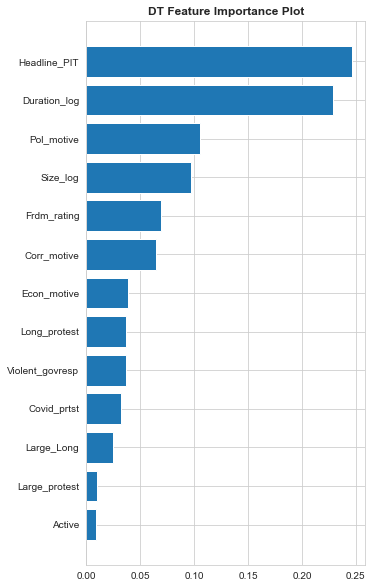

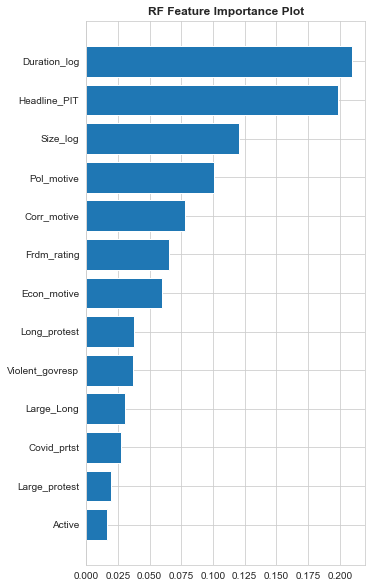

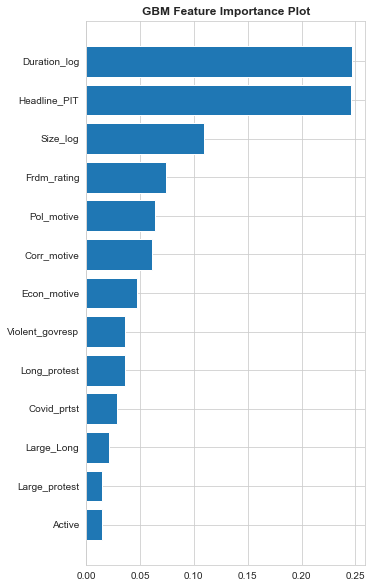

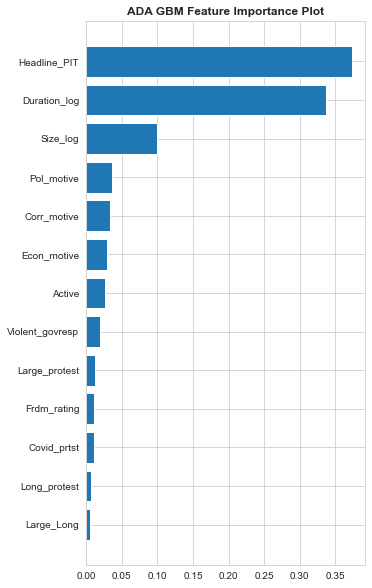

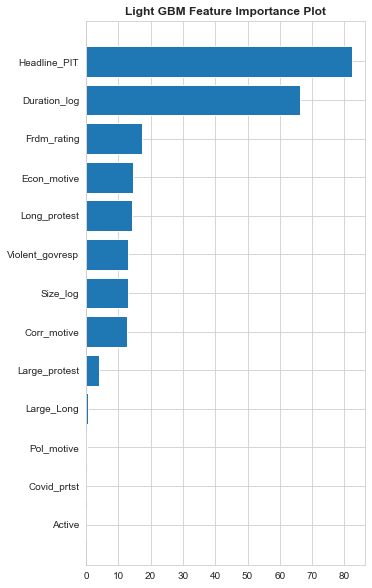

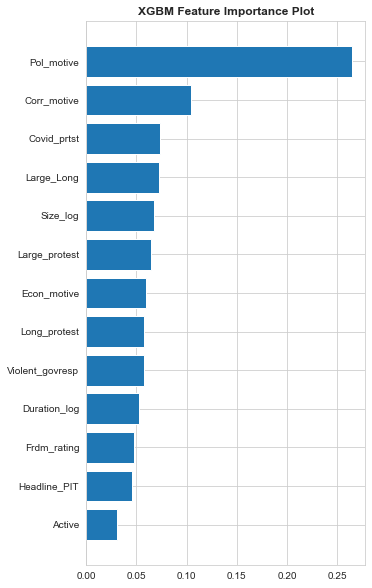

In [22]:
start_time = time.time()
a_norm = train_knn(X,y)
start_time = time.time()
b_norm = train_logistic(X,y, reg='l1')
start_time = time.time()
c_norm = train_logistic(X,y, reg='l2')
start_time = time.time()
d_norm = train_svm(X,y,reg='l2')
start_time = time.time()
e_norm = train_svm(X,y,reg='l1')
start_time = time.time()
f_norm = train_DT(X,y,reg='none')
start_time = time.time()
g_norm = train_RF(X,y,reg='none')
start_time = time.time()
h_norm = train_GBM(X,y,reg='none')
start_time = time.time()
i_norm = train_ADAGBM(X,y,reg='none')
start_time = time.time()
j_norm = train_LGBM(X,y,reg='none')
start_time = time.time()
k_norm = train_XGBM(X,y,reg='none')


cols = ['Machine Learning Method',
         'Train Accuracy',
        'Test Accuracy',
         'Best Parameter',
         'Top Predictor Variable',
         'Run Time']

df5 = pd.DataFrame(columns=cols)


df5.loc[0] = a_norm
df5.loc[1] = b_norm
df5.loc[2] = c_norm
df5.loc[3] = d_norm
df5.loc[4] = e_norm
df5.loc[5] = f_norm
df5.loc[6] = g_norm
df5.loc[7] = h_norm
df5.loc[8] = i_norm
df5.loc[9] = j_norm
df5.loc[10] = k_norm



df5
df5.sort_values('Test Accuracy', ascending=False)

<h2 style="color: darkorange">Results and Discussion</h2>

<span style="font-size: 16px">

Before running models, the dataset was balanced using random undersampling with `imblearn`. The dataset was then scaled using the standard scaler.

In the Baseline Performance, the **`GBM`** method returned the highest test accuracy at 62.27%. Note however, that this is lower than the 1.25PCC of 62.50%.The different models also returned different top predictor variables namely, `Duration_log`, `Frdm_rating`, and `Pol_motive`. As expected, **`kNN`** also has the longest run time at 921s.

After parameters tuning using `itertools`, the **`GBM`** model still returned the highest test accuracy of 64.22%. The other models that had a test accuracy higher than 1.25PCC is **`Random Forest`**. The top predictor for both models is `Duration_log`.

Understandably, it would seem that the longer the protest duration the more likely that it will result in a positive outcome or policy change. Therefore, grit and persistence is key to achieve change. The top three features of both **`GBM`** and **`Random Forest`** are `Duration_log`, `Headline_PIT`, and `Size_log`. Having `Headline_PIT` as an important feature is likely because taxation fosters accountability between the government and civil society. Also a top feature is the size of the protests, whether it was attended by thousands or millions of protesters.
    
In terms of run time,  the **`GBM`** method took the longest to run with a run time of 9513 seconds. This may be due to the number of parameters that the model is tuning. Next to **`GBM`** is **`linear SVM (l2)`** method with run time  of 7025 seconds. The `max_iter` was increased to 10 million as the model continuously failed to converge.


<h2 style="color: darkorange">Conclusion</h2>

<span style="font-size: 16px">
    
The top performing models returned results higher than the 1.25PCC, but the highest test accuracy score of 64.22% is considerably low. Although the top predictors can intuitively be explained to lead to positive outcome/policy change, further testing of significance was not done. 

Given resource limitation (computing power and time) and capacity of learner, the following were not done and are suggested be included in future analysis:

1. Try other methods of correcting class imbalance and compare results,
2. Increase simulation size, and
3. Add features that affects protests and outcomes of protests based on literature review, e.g., chances of rain. 

Over time, the tracker will hopefully have more data available to work on.

<h2 style="color: darkorange">References</h2>

<span style="font-size: 16px">

1. see Punctuated Equilibrium Theory. 
2. Carnegie Endowment for International Peace. Global Protest Tracker [last updated, 2022, November 9]. \
Retrieved from https://carnegieendowment.org/publications/interactive/protest-tracker
3. Headline Personal Income Tax. (collated from various sources) \
PricewaterhouseCoopers.Personal income tax (PIT) rates (main source). \
Retrieved from https://taxsummaries.pwc.com/quick-charts/personal-income-tax-pit-rates
4. Analytics Vidhya Website (2022, July 19). Imbalanced Classification: Handling Imbalanced Data using Python. Retrieved from https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/



Submitted by: Ranna Pintor | MSDS 2023